# Figure 7: IRASA cannot characterize oscillation peaks that are not clearly separable

In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import yaml
from fooof.sim.gen import gen_aperiodic
from scipy.signal import sawtooth

from utils import elec_phys_signal, irasa


def IRASA_fit(data: np.array, freq_range: (int, int), cond: str):
    """
    Return aperiodic fit and corresponding label.

    Parameters
    ----------
    data : np.array
        Time series data.
    freq_range : tuple of int
        Fitting range.
    cond : str
        Condition.

    Returns
    -------
    tuple(ndarray, str)
        (aperiodic fit, plot label).
    """
    _, _, _, params = irasa(data, sf=sample_rate, band=freq_range)
    exp = -params["Slope"][0]
    intercept = params["Intercept"][0]
    label = fr"$\beta_{{{cond}}}$={exp:.2f}"
    ap_fit = gen_aperiodic(freq, [intercept, exp])
    return 10**ap_fit, label

#### Load params and make directory

In [2]:
yaml_file = open('params.yml')
parsed_yaml_file = yaml.load(yaml_file, Loader=yaml.FullLoader)
globals().update(parsed_yaml_file)

Path(fig_path).mkdir(parents=True, exist_ok=True)

#### Set EEG and Welch params and state seizure time points

In [3]:
# %% EEG Params
sample_rate = 256
electrode = "F3-C3"

# Seizure sample timepoints
seiz_start_samples = 87800  # keep
seiz_end_samples = 91150  # keep
seiz_len_samples = seiz_end_samples - seiz_start_samples  # keep

# Welch Params
nperseg = sample_rate
welch_params = {"fs": sample_rate, "nperseg": nperseg}

#### Load empirical data of dataset 3 and calc PSD

In [4]:
# %% Load data
data_path = "../data/Fig4+7/"
seiz_data = np.load(data_path + electrode + ".npy", allow_pickle=True)

# Select seizure time points
slice_full = slice(seiz_start_samples - seiz_len_samples,
                   seiz_end_samples + seiz_len_samples)
slice_pre_seiz = slice(seiz_start_samples - seiz_len_samples,
                       seiz_start_samples)
slice_seiz = slice(seiz_start_samples, seiz_end_samples)
slice_post_seiz = slice(seiz_end_samples, seiz_end_samples + seiz_len_samples)

data_full = seiz_data[slice_full]
time_full = np.linspace(0, data_full.size/sample_rate, num=data_full.size)
data_pre = seiz_data[slice_pre_seiz]
data_seiz = seiz_data[slice_seiz]
data_post = seiz_data[slice_post_seiz]

# Calc psd pre, post, seiz
freq, psd_EEG_pre = sig.welch(data_pre, **welch_params)
freq, psd_EEG_seiz = sig.welch(data_seiz, **welch_params)
freq, psd_EEG_post = sig.welch(data_post, **welch_params)

#### Simulate sawtooth signal of same length

In [5]:
# Sawtooth Parameters
saw_power = 0.02
saw_width = 0.69
freq_saw = 3  # Hz
time_seiz = np.linspace(0, data_seiz.size/sample_rate, num=data_seiz.size)

# Make Signal
saw = sawtooth(2 * np.pi * freq_saw * time_seiz, width=saw_width)
saw *= saw_power  # scaling

# make signal 10 seconds zero, 10 seconds strong, 10 seconds zero
saw_full = np.r_[np.zeros(seiz_len_samples),
                 saw,
                 np.zeros(seiz_len_samples)]

# add two broad overlapping oscillations
peak_center_freq1 = 10
peak_center_freq2 = 25
peak_amplitude = .5e5
peak_width1 = 3.5
peak_width2 = 15

periodic_params = [(peak_center_freq1, peak_amplitude, peak_width1),
                   (peak_center_freq2, peak_amplitude, peak_width2)]
seed = 2
exponent_sim_oscs = 0
duration = time_seiz[-1] + 2/sample_rate  # two time units lost during Fourier
_, full_signal = elec_phys_signal(exponent_sim_oscs,
                                  periodic_params=periodic_params,
                                  sample_rate=sample_rate, duration=duration,
                                  seed=seed, highpass=True)
full_signal /= 1e4  # decrease white noise
osc_full = np.r_[np.zeros(seiz_len_samples),
                 full_signal,
                 np.zeros(seiz_len_samples)]

# Create 1/f noise and add
exponent_sim = 1.8
duration = time_full[-1] + 2/sample_rate  # two time units lost during Fourier
noise, _ = elec_phys_signal(exponent_sim, sample_rate=sample_rate,
                            duration=duration, seed=seed, highpass=True)
noise_saw = noise + saw_full
noise_saw_osc = noise + saw_full + osc_full

# normalize
norm = lambda x: (x - x.mean()) / x.std()
noise_saw = norm(noise_saw)
noise_saw_osc = norm(noise_saw_osc)

# Calc PSDs saw
saw_pre = noise_saw[:seiz_len_samples]
saw_seiz = noise_saw[seiz_len_samples:2*seiz_len_samples]
saw_post = noise_saw[2*seiz_len_samples:]

freq, psd_saw_pre = sig.welch(saw_pre, **welch_params)
freq, psd_saw_seiz = sig.welch(saw_seiz, **welch_params)
freq, psd_saw_post = sig.welch(saw_post, **welch_params)

# Calc PSDs saw_osc
saw_osc_pre = noise_saw_osc[:seiz_len_samples]
saw_osc_seiz = noise_saw_osc[seiz_len_samples:2*seiz_len_samples]
saw_osc_post = noise_saw_osc[2*seiz_len_samples:]

freq, psd_saw_osc_pre = sig.welch(saw_osc_pre, **welch_params)
freq, psd_saw_osc_seiz = sig.welch(saw_osc_seiz, **welch_params)
freq, psd_saw_osc_post = sig.welch(saw_osc_post, **welch_params)

#### Apply IRASA

In [6]:
# Calc irasa pre-, post-, and during seizure
freq_range = [1, 100]

fit_pre_eeg, lab_pre_eeg = IRASA_fit(data_pre, freq_range, "pre ")
fit_seiz_eeg, lab_seiz_eeg = IRASA_fit(data_seiz, freq_range, "seiz")
fit_post_eeg, lab_post_eeg = IRASA_fit(data_post, freq_range, "post")

fit_pre_sim, lab_pre_saw = IRASA_fit(saw_pre, freq_range, "pre ")
fit_seiz_sim, lab_seiz_saw = IRASA_fit(saw_seiz, freq_range, "seiz")
fit_post_sim, lab_post_saw = IRASA_fit(saw_post, freq_range, "post")

fit_pre_sim_osc, lab_pre_saw_osc = IRASA_fit(saw_pre, freq_range, "pre ")
fit_seiz_sim_osc, lab_seiz_saw_osc = IRASA_fit(saw_osc_seiz,
                                               freq_range, "seiz")
fit_post_sim_osc, lab_post_saw_osc = IRASA_fit(saw_post, freq_range, "post")

/opt/anaconda3/envs/one-over-f/lib/python3.9/site-packages/fooof/core/funcs.py:95: RuntimeWarning: divide by zero encountered in log10
  ys = ys + offset - np.log10(xs**exp)


#### Plot settings

In [7]:
# %% mpl settings
mpl.rcParams['xtick.labelsize'] = legend_fontsize
mpl.rcParams['ytick.labelsize'] = legend_fontsize
mpl.rcParams['axes.labelsize'] = legend_fontsize
mpl.rcParams['legend.fontsize'] = legend_fontsize
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

# tick params
ticks_time = dict(length=6, width=1.5)
ticks_psd = dict(length=4, width=1)
panel_labels = dict(x=0, y=1.02, fontsize=panel_fontsize,
                    fontdict=dict(fontweight="bold"))

# a1
# EEG Time Series
yticks_a1 = [-250, 0, 200]
yticklabels_a1 = [-250, "", 200]
xlim_a1 = (0, time_full[-1])
ylabel_a1 = fr"{electrode} [$\mu$V]"
ymin = -250
ylim_a1 = (ymin, 200)
axes_a1 = dict(yticks=yticks_a1, yticklabels=yticklabels_a1, xlim=xlim_a1,
               ylim=ylim_a1)

# a2
xticks_a2 = [1, 10, 100]
xticklabels_a2 = []
yticks_a2 = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
yticklabels_a2 = [r"$10^{-2}$", "", "", "", "", "", "", r"$10^5$"]
ylim_a2 = (yticks_a2[0], yticks_a2[-1])
xlim_a2 = freq_range
ylabel_a2 = r"PSD [$\mu$$V^2$/Hz]"
xlabel_a2 = ""
axes_a2 = dict(xticks=xticks_a2, xticklabels=xticklabels_a2,
               yticks=yticks_a2, yticklabels=yticklabels_a2, ylim=ylim_a2,
               xlim=xlim_a2, xlabel=xlabel_a2,
               ylabel=ylabel_a2)

# b1
y_max = np.abs(noise_saw).max() * 1.1
yticks_b = (-3.5, 0, 3.5)
yticklabels_b = (-3.5, "", 3.5)
xlim_b = (0, time_full[-1])
ylim_b = (yticks_b[0], yticks_b[-1])
xlabel_b = "Time [s]"
ylabel_b = "Simulation [a.u.]"
axes_b = dict(yticks=yticks_b, yticklabels=yticklabels_b,
              xlim=xlim_b, ylim=ylim_b, xlabel=xlabel_b)

# b2
yticks_b2 = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
yticklabels_b2 = [r"$10^{-6}$", "", "", "", "", "", "", "", r"$10^2$"]
ylim_b2 = (yticks_b2[0], yticks_b2[-1])
xlabel_b2 = "Frequency [Hz]"
ylabel_b2 = "PSD [a.u.]"
axes_b2 = dict(xticks=xticks_a2, xticklabels=xticks_a2, yticks=yticks_b2,
               yticklabels=yticklabels_b2, ylim=ylim_b2,
               xlim=xlim_a2, xlabel=xlabel_b2)

# Rectangles to mark pre-, seizure, post
rect_height = np.abs(data_full).max() * 2
rect = dict(height=rect_height, alpha=0.2)

start_pre = 0
start_seiz = seiz_len_samples / sample_rate
start_post = 2*seiz_len_samples / sample_rate

xy_pre = (start_pre, ymin)
xy_seiz = (start_seiz, ymin)
xy_post = (start_post, ymin)

width = seiz_len_samples / sample_rate

# Add colored rectangles
rect_EEG_pre_params = dict(xy=xy_pre, width=width, color=c_pre, **rect)
rect_EEG_seiz_params = dict(xy=xy_seiz, width=width, color=c_seiz, **rect)
rect_EEG_post_params = dict(xy=xy_post, width=width, color=c_post, **rect)


def add_rectangles(ax):
    """Plot three colored rectangles in the time series to distinguish
    pre-, seiz- and post activity."""
    rect_EEG_pre = plt.Rectangle(**rect_EEG_pre_params)
    rect_EEG_seiz = plt.Rectangle(**rect_EEG_seiz_params)
    rect_EEG_post = plt.Rectangle(**rect_EEG_post_params)
    ax.add_patch(rect_EEG_pre)
    ax.add_patch(rect_EEG_seiz)
    ax.add_patch(rect_EEG_post)

# Figure 7

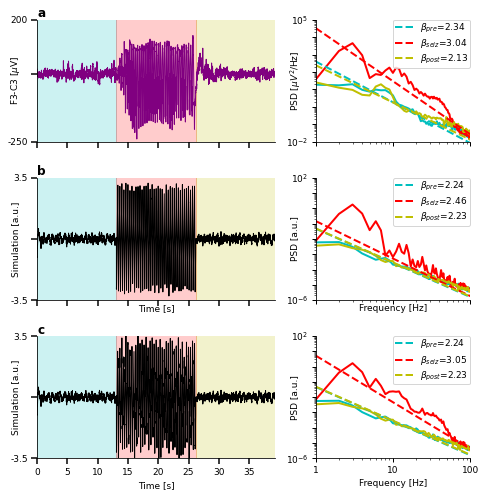

In [8]:
fig, axes = plt.subplots(3, 2, figsize=[fig_width, 7], sharex="col",
                         gridspec_kw=dict(width_ratios=[1, .65]))

# a1
# Plot EEG seizure
ax = axes[0, 0]
ax.plot(time_full, data_full, c=c_real, lw=1)
add_rectangles(ax)

# Set axes
ax.set(**axes_a1)
ax.set_ylabel(ylabel_a1, labelpad=-15)
ax.tick_params(**ticks_time)
ax.text(s="a", **panel_labels, transform=ax.transAxes)

# a2
# Plot EEG PSD
ax = axes[0, 1]
ax.loglog(freq, psd_EEG_pre, c_pre, lw=2)
ax.loglog(freq, psd_EEG_seiz, c_seiz, lw=2)
ax.loglog(freq, psd_EEG_post, c_post, lw=2)

# Plot EEG fooof fit
ax.loglog(freq, fit_pre_eeg, "--", c=c_pre, lw=2, label=lab_pre_eeg)
ax.loglog(freq, fit_seiz_eeg, "--", c=c_seiz, lw=2, label=lab_seiz_eeg)
ax.loglog(freq, fit_post_eeg, "--", c=c_post, lw=2, label=lab_post_eeg)

# Set axes
ax.set(**axes_a2)
ax.legend(borderaxespad=0, labelspacing=.3, borderpad=.2)
ax.set_ylabel(ylabel_a2, labelpad=-17)
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, 0.1), numticks=10)
ax.yaxis.set_minor_locator(y_minor)
ax.tick_params(**ticks_psd)

# b1
# Sawtooth Time Series
ax = axes[1, 0]
ax.plot(time_full, noise_saw, c=c_sim, lw=1)
add_rectangles(ax)

# Set axes
ax.set(**axes_b)
ax.set_ylabel(ylabel_b, labelpad=-10)
ax.tick_params(**ticks_time)
ax.text(s="b", **panel_labels, transform=ax.transAxes)

# b2
# Plot saw PSD
ax = axes[1, 1]
ax.loglog(freq, psd_saw_pre, c_pre, lw=2)
ax.loglog(freq, psd_saw_seiz, c_seiz, lw=2)
ax.loglog(freq, psd_saw_post, c_post, lw=2)

# Plot Saw fooof fit
ax.loglog(freq, fit_pre_sim, "--", c=c_pre, lw=2, label=lab_pre_saw)
ax.loglog(freq, fit_seiz_sim, "--", c=c_seiz, lw=2, label=lab_seiz_saw)
ax.loglog(freq, fit_post_sim, "--", c=c_post, lw=2, label=lab_post_saw)

# Set axes
ax.set(**axes_b2)
ax.legend(borderaxespad=0, labelspacing=.3, borderpad=.2)
ax.set_ylabel(ylabel_b2, labelpad=-13)
ax.tick_params(**ticks_psd)
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, 0.1), numticks=10)
ax.yaxis.set_minor_locator(y_minor)

# c1
# Sawtooth Time Series + Alpha Beta
ax = axes[2, 0]
ax.plot(time_full, noise_saw_osc, c=c_sim, lw=1)
add_rectangles(ax)

# Set axes
ax.set(**axes_b)
ax.set_ylabel(ylabel_b, labelpad=-10)
ax.tick_params(**ticks_time)
ax.text(s="c", **panel_labels, transform=ax.transAxes)

# c2
# Plot saw PSD
ax = axes[2, 1]
ax.loglog(freq, psd_saw_osc_pre, c_pre, lw=2)
ax.loglog(freq, psd_saw_osc_seiz, c_seiz, lw=2)
ax.loglog(freq, psd_saw_osc_post, c_post, lw=2)

# Plot Saw fooof fit
ax.loglog(freq, fit_pre_sim_osc, "--", c=c_pre, lw=2, label=lab_pre_saw_osc)
ax.loglog(freq, fit_seiz_sim_osc, "--", c=c_seiz, lw=2, label=lab_seiz_saw_osc)
ax.loglog(freq, fit_post_sim_osc, "--", c=c_post, lw=2, label=lab_post_saw_osc)

# Set axes
ax.set(**axes_b2)
ax.legend(borderaxespad=0, labelspacing=.3, borderpad=.2)
ax.set_ylabel(ylabel_b2, labelpad=-13)
ax.tick_params(**ticks_psd)
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, 0.1), numticks=10)
ax.yaxis.set_minor_locator(y_minor)

plt.tight_layout()
plt.savefig(fig_path + "Fig7.pdf", bbox_inches="tight")
plt.savefig(fig_path + "Fig7.png", dpi=1000, bbox_inches="tight")
plt.show()

# Supplementary figure: Show IRASA results

In [9]:
# Apply IRASA
freqs, aperiodic_EEG_pre, periodic_EEG_pre, params_EEG_pre = \
                        irasa(data_pre, sf=sample_rate, band=freq_range)
_, aperoidic_EEG_seiz, periodic_EEG_seiz, params_EEG_seiz = \
                        irasa(data_seiz, sf=sample_rate, band=freq_range)
_, aperoidic_EEG_post, periodic_EEG_post, params_EEG_post = \
                        irasa(data_post, sf=sample_rate, band=freq_range)

_, aperoidic_saw_pre, periodic_saw_pre, params_saw_pre = \
                        irasa(saw_pre, sf=sample_rate, band=freq_range)
_, aperiodic_saw_seiz, periodic_saw_seiz, params_saw_seiz = \
                        irasa(saw_seiz, sf=sample_rate, band=freq_range)
_, aperiodic_saw_post, periodic_saw_post, params_saw_post = \
                        irasa(saw_post, sf=sample_rate, band=freq_range)

_, ap_saw_osc_seiz, osc_saw_osc_seiz, params_saw_osc_seiz = \
                        irasa(saw_osc_seiz, sf=sample_rate, band=freq_range)

# Extract results
exponent_EEG_pre = -params_EEG_pre["Slope"][0]
intercept_EEG_pre = params_EEG_pre["Intercept"][0]
exponent_EEG_seiz = -params_EEG_seiz["Slope"][0]
intercept_EEG_seiz = params_EEG_seiz["Intercept"][0]
exponent_EEG_post = -params_EEG_post["Slope"][0]
intercept_EEG_post = params_EEG_post["Intercept"][0]

exponent_saw_pre = -params_saw_pre["Slope"][0]
intercept_saw_pre = params_saw_pre["Intercept"][0]
exponent_saw_seiz = -params_saw_seiz["Slope"][0]
intercept_saw_seiz = params_saw_seiz["Intercept"][0]
exponent_saw_post = -params_saw_post["Slope"][0]
intercept_saw_post = params_saw_post["Intercept"][0]

exponent_saw_osc_seiz = -params_saw_osc_seiz["Slope"][0]
intercept_saw_osc_seiz = params_saw_osc_seiz["Intercept"][0]

# Generate 1/f based on results
ap_fit_EEG_pre = gen_aperiodic(freqs, [intercept_EEG_pre, exponent_EEG_pre])
ap_fit_EEG_seiz = gen_aperiodic(freqs, [intercept_EEG_seiz, exponent_EEG_seiz])
ap_fit_EEG_post = gen_aperiodic(freqs, [intercept_EEG_post, exponent_EEG_post])

ap_fit_saw_pre = gen_aperiodic(freqs, [intercept_saw_pre, exponent_saw_pre])
ap_fit_saw_seiz = gen_aperiodic(freqs, [intercept_saw_seiz, exponent_saw_seiz])
ap_fit_saw_post = gen_aperiodic(freqs, [intercept_saw_post, exponent_saw_post])

ap_fit_saw_osc_seiz = gen_aperiodic(freqs,
                                    [intercept_saw_osc_seiz,
                                     exponent_saw_osc_seiz])

#### Plot Supplementary Material

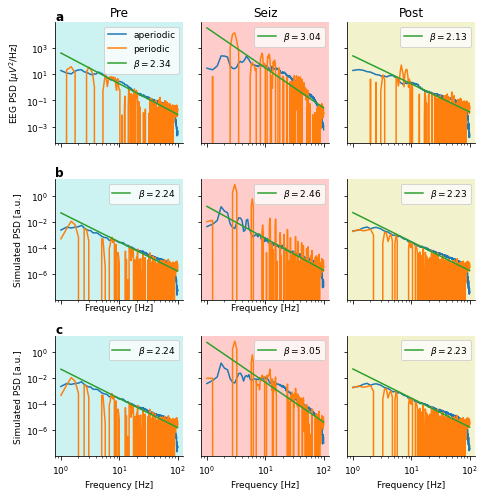

In [10]:
fig, ax = plt.subplots(3, 3, figsize=[fig_width, 7], sharex=True, sharey="row")

ax[0, 0].set_title("Pre")
ax[0, 0].loglog(freqs, aperiodic_EEG_pre[0], label="aperiodic")
ax[0, 0].loglog(freqs, periodic_EEG_pre[0], label="periodic")
ax[0, 0].loglog(freqs, 10**ap_fit_EEG_pre,
                label=fr"$\beta=${exponent_EEG_pre:.2f}")
ax[0, 0].legend()
ax[0, 0].text(s="a", **panel_labels, transform=ax[0, 0].transAxes)
ax[0, 0].set_ylabel(r"EEG PSD [$\mu$$V^2$/Hz]")

ax[0, 1].set_title("Seiz")
ax[0, 1].loglog(freqs, aperoidic_EEG_seiz[0])
ax[0, 1].loglog(freqs, periodic_EEG_seiz[0])
ax[0, 1].loglog(freqs, 10**ap_fit_EEG_seiz,
                label=fr"$\beta=${exponent_EEG_seiz:.2f}")
ax[0, 1].legend()

ax[0, 2].set_title("Post")
ax[0, 2].loglog(freqs, aperoidic_EEG_post[0])
ax[0, 2].loglog(freqs, periodic_EEG_post[0])
ax[0, 2].loglog(freqs, 10**ap_fit_EEG_post,
                label=fr"$\beta=${exponent_EEG_post:.2f}")
ax[0, 2].legend()

ax[1, 0].set_ylabel("Simulated PSD [a.u.]")
ax[1, 0].loglog(freqs, aperoidic_saw_pre[0])
ax[1, 0].loglog(freqs, periodic_saw_pre[0])
ax[1, 0].loglog(freqs, 10**ap_fit_saw_pre,
                label=fr"$\beta=${exponent_saw_pre:.2f}")
ax[1, 0].legend()
ax[1, 0].set_xlabel("Frequency [Hz]")
ax[1, 0].text(s="b", **panel_labels, transform=ax[1, 0].transAxes)

ax[1, 1].loglog(freqs, aperiodic_saw_seiz[0])
ax[1, 1].loglog(freqs, periodic_saw_seiz[0])
ax[1, 1].loglog(freqs, 10**ap_fit_saw_seiz,
                label=fr"$\beta=${exponent_saw_seiz:.2f}")
ax[1, 1].legend()
ax[1, 1].set_xlabel("Frequency [Hz]")

ax[1, 2].loglog(freqs, aperiodic_saw_post[0])
ax[1, 2].loglog(freqs, periodic_saw_post[0])
ax[1, 2].loglog(freqs, 10**ap_fit_saw_post,
                label=fr"$\beta=${exponent_saw_post:.2f}")
ax[1, 2].legend()

ax[2, 0].set_ylabel("Simulated PSD [a.u.]")

ax[2, 0].loglog(freqs, aperoidic_saw_pre[0])
ax[2, 0].loglog(freqs, periodic_saw_pre[0])
ax[2, 0].loglog(freqs, 10**ap_fit_saw_pre,
                label=fr"$\beta=${exponent_saw_pre:.2f}")
ax[2, 0].legend()
ax[2, 0].set_xlabel("Frequency [Hz]")
ax[2, 0].text(s="c", **panel_labels, transform=ax[2, 0].transAxes)

ax[2, 1].loglog(freqs, ap_saw_osc_seiz[0])
ax[2, 1].loglog(freqs, osc_saw_osc_seiz[0])
ax[2, 1].loglog(freqs, 10**ap_fit_saw_osc_seiz,
                label=fr"$\beta=${exponent_saw_osc_seiz:.2f}")
ax[2, 1].legend()
ax[2, 1].set_xlabel("Frequency [Hz]")

ax[2, 2].loglog(freqs, aperiodic_saw_post[0])
ax[2, 2].loglog(freqs, periodic_saw_post[0])
ax[2, 2].loglog(freqs, 10**ap_fit_saw_post,
                label=fr"$\beta=${exponent_saw_post:.2f}")
ax[2, 2].legend()
ax[2, 2].set_xlabel("Frequency [Hz]")

# Add colored rectangles
ax[0, 0].patch.set_facecolor(c_pre)
ax[0, 0].patch.set_alpha(rect["alpha"])
ax[1, 0].patch.set_facecolor(c_pre)
ax[1, 0].patch.set_alpha(rect["alpha"])
ax[2, 0].patch.set_facecolor(c_pre)
ax[2, 0].patch.set_alpha(rect["alpha"])

ax[0, 1].patch.set_facecolor(c_seiz)
ax[0, 1].patch.set_alpha(rect["alpha"])
ax[1, 1].patch.set_facecolor(c_seiz)
ax[1, 1].patch.set_alpha(rect["alpha"])
ax[2, 1].patch.set_facecolor(c_seiz)
ax[2, 1].patch.set_alpha(rect["alpha"])

ax[0, 2].patch.set_facecolor(c_post)
ax[0, 2].patch.set_alpha(rect["alpha"])
ax[1, 2].patch.set_facecolor(c_post)
ax[1, 2].patch.set_alpha(rect["alpha"])
ax[2, 2].patch.set_facecolor(c_post)
ax[2, 2].patch.set_alpha(rect["alpha"])

plt.tight_layout()
plt.savefig(fig_path + "Fig7_Supp_loglog.pdf", bbox_inches="tight")
plt.savefig(fig_path + "Fig7_Supp_loglog.png", dpi=1000, bbox_inches="tight")
plt.show()